# Machine learning for anomaly detection and condition monitoring

 Download dataset from https://www.kaggle.com/datasets/vinayak123tyagi/bearing-dataset


In [52]:
# Common imports
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten,BatchNormalization,Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
data = pd.read_csv('C:/Users/Nihar/Desktop/PhD Course Work/Condition Monitoring/Condition monitoring/2nd_test/2004.02.12.10.32.39',sep='\t',header=None)
data

,0,1,2,3
0,-0.049,-0.071,-0.132,-0.010
1,-0.042,-0.073,-0.007,-0.105
2,0.015,0.000,0.007,0.000
3,-0.051,0.020,-0.002,0.100
4,-0.107,0.010,0.127,0.054
...,...,...,...,...
20475,0.049,-0.051,-0.039,-0.044
20476,0.037,0.061,0.115,0.007
20477,-0.012,0.007,0.056,-0.007
20478,-0.012,0.093,0.017,-0.044


In [3]:
data.abs().mean()

0    0.058332
1    0.071832
2    0.083244
3    0.043065
dtype: float64

In [4]:
data_file = ['2nd_test','3rd_test']
merged_data = pd.DataFrame()
for data_dir in data_file:
    for filename in os.listdir(data_dir):
        #print(filename)
        dataset=pd.read_csv(os.path.join(data_dir, filename), sep='\t')
        dataset_mean_abs = np.array(dataset.abs().mean())
        dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
        dataset_mean_abs.index = [filename]
        merged_data = merged_data.append(dataset_mean_abs)

merged_data.columns = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']

In [7]:
merged_data

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
...,...,...,...,...
2004-04-18 02:02:55,0.122483,0.188266,0.342773,0.195169
2004-04-18 02:12:55,0.110250,0.166027,0.331777,0.205829
2004-04-18 02:22:55,0.115789,0.201599,0.404317,0.222174
2004-04-18 02:32:55,0.119909,0.199330,0.543770,0.229026


In [8]:
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('Bearing_dataset.csv')
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


# Traing and testing splitt

In [10]:
len(merged_data.index)

7308

In [15]:
# Total data is 7308, around 80% data is saved as train, 20% as test
len(merged_data[:'2004-04-08 23:59:59'])

6037

<Axes: >

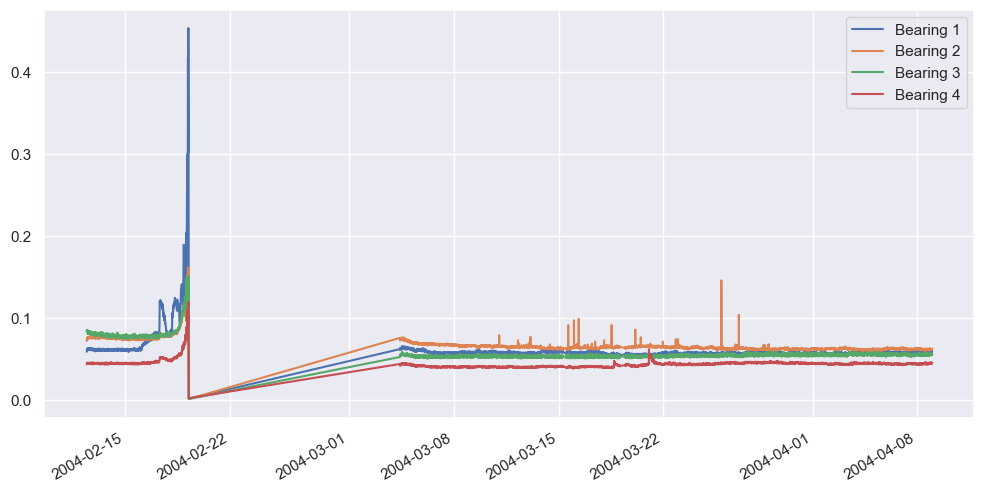

In [16]:
dataset_train = merged_data[:'2004-04-08 23:59:59']
dataset_test = merged_data['2004-04-09 00:00:00':]
dataset_train.plot(figsize = (12,6))

<Axes: >

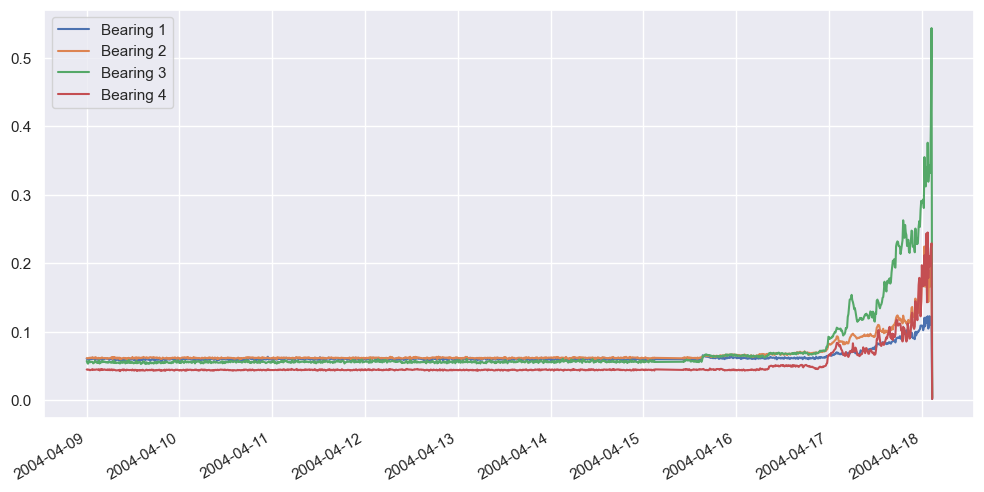

In [17]:
dataset_test.plot(figsize = (12,6))

In [18]:
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(dataset_train), 
                              columns=dataset_train.columns, 
                              index=dataset_train.index)
# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(dataset_test), 
                             columns=dataset_test.columns, 
                             index=dataset_test.index)

In [19]:
X_train

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.126423,0.443462,0.548041,0.352522
2004-02-12 10:42:39,0.127888,0.457029,0.555967,0.365087
2004-02-12 10:52:39,0.130633,0.458408,0.552584,0.364252
2004-02-12 11:02:39,0.133329,0.456021,0.556113,0.369692
2004-02-12 11:12:39,0.133120,0.467033,0.545350,0.370007
...,...,...,...,...
2004-04-08 23:11:57,0.129935,0.381410,0.364507,0.368443
2004-04-08 23:21:57,0.125225,0.374089,0.356569,0.358697
2004-04-08 23:31:57,0.127372,0.376324,0.370050,0.359149
2004-04-08 23:41:57,0.127659,0.378453,0.366789,0.363315


In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver= 'full')
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

In [21]:
X_test_PCA

,0,1
2004-04-09 00:01:57,-0.015918,0.008648
2004-04-09 00:11:57,-0.029157,0.020420
2004-04-09 00:21:57,-0.038370,0.019263
2004-04-09 00:31:57,-0.023798,0.013295
2004-04-09 00:41:57,-0.015102,0.004477
...,...,...
2004-04-18 02:02:55,2.238359,-0.191496
2004-04-18 02:12:55,2.142119,-0.113063
2004-04-18 02:22:55,2.652008,-0.289029
2004-04-18 02:32:55,3.352745,-0.768295


<Axes: >

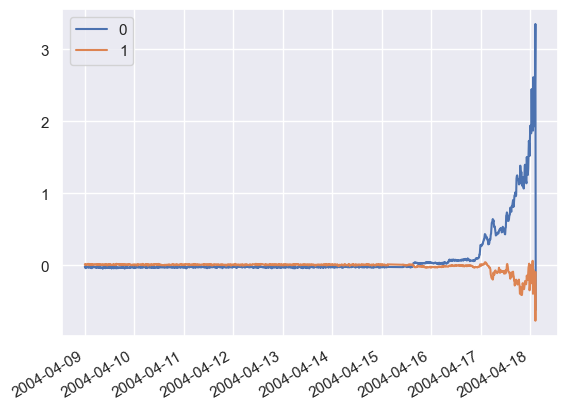

In [40]:
X_test_PCA.plot()

In [22]:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [23]:
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

In [24]:
def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [25]:
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

In [26]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [27]:
data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

In [28]:
cov_matrix, inv_cov_matrix  = cov_matrix(data_train)

In [29]:
mean_distr = data_train.mean(axis=0)

In [30]:
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)

(0.0, 15.0)

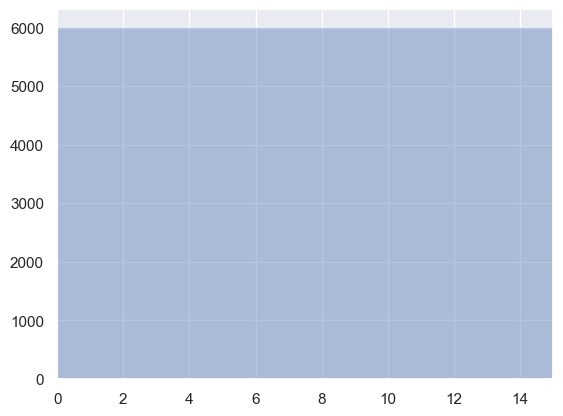

In [31]:
plt.figure()
sns.distplot(np.square(dist_train),
             bins = 10, 
             kde= False);
plt.xlim([0.0,15])

Text(0.5, 0, 'Mahalanobis dist')

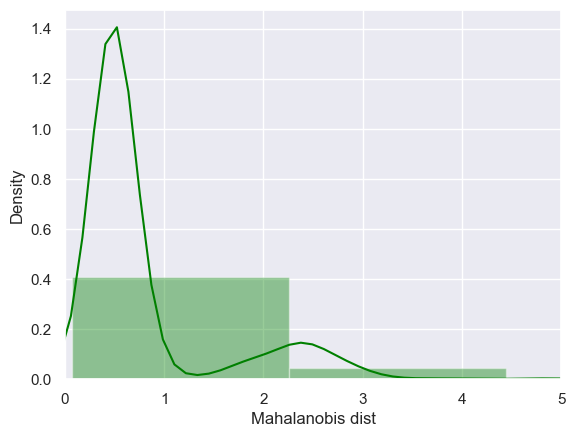

In [32]:
plt.figure()
sns.distplot(dist_train,
             bins = 10, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

In [33]:
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist']= dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index
anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()

,Mob dist,Thresh,Anomaly
2004-04-09 00:01:57,0.312067,2.604587,False
2004-04-09 00:11:57,0.696762,2.604587,False
2004-04-09 00:21:57,0.710757,2.604587,False
2004-04-09 00:31:57,0.476288,2.604587,False
2004-04-09 00:41:57,0.206090,2.604587,False


In [34]:
anomaly['Anomaly'].value_counts()

False    1109
True      162
Name: Anomaly, dtype: int64

In [35]:
anomaly_alldata = pd.concat([anomaly_train, anomaly])
anomaly_alldata.to_csv('Anomaly_distance.csv')

<Figure size 2000x600 with 0 Axes>

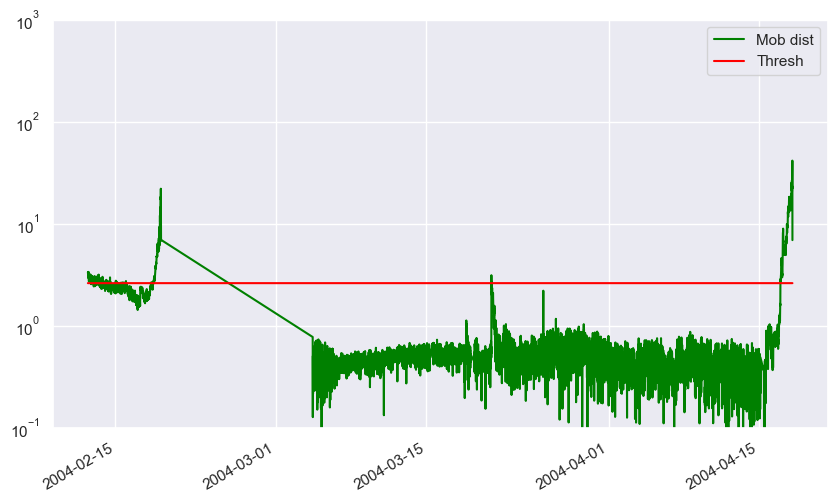

In [103]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
anomaly_alldata.plot(logy=True, figsize = (10,6), ylim = [1e-1,1e3], color = ['green','red'])
plt.savefig('anamoly.jpg')

In [38]:
anomaly_train

,Mob dist,Thresh,Anomaly
2004-02-12 10:32:39,3.332451,2.604587,True
2004-02-12 10:42:39,3.293231,2.604587,True
2004-02-12 10:52:39,3.206920,2.604587,True
2004-02-12 11:02:39,3.153325,2.604587,True
2004-02-12 11:12:39,2.972314,2.604587,True
...,...,...,...
2004-04-08 23:11:57,0.524785,2.604587,False
2004-04-08 23:21:57,0.495728,2.604587,False
2004-04-08 23:31:57,0.281771,2.604587,False
2004-04-08 23:41:57,0.381432,2.604587,False


In [39]:
from sklearn.preprocessing import LabelEncoder

In [46]:
X_train

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.126423,0.443462,0.548041,0.352522
2004-02-12 10:42:39,0.127888,0.457029,0.555967,0.365087
2004-02-12 10:52:39,0.130633,0.458408,0.552584,0.364252
2004-02-12 11:02:39,0.133329,0.456021,0.556113,0.369692
2004-02-12 11:12:39,0.133120,0.467033,0.545350,0.370007
...,...,...,...,...
2004-04-08 23:11:57,0.129935,0.381410,0.364507,0.368443
2004-04-08 23:21:57,0.125225,0.374089,0.356569,0.358697
2004-04-08 23:31:57,0.127372,0.376324,0.370050,0.359149
2004-04-08 23:41:57,0.127659,0.378453,0.366789,0.363315


In [45]:
X_train.shape

(6037, 4)

In [47]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(anomaly_train['Anomaly'])
y_test = encoder.transform(anomaly['Anomaly'])

In [48]:
y_train

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

# ANN Predictive model

In [53]:
# Shallow Neural Naetwork
model = Sequential()

model.add(Dense(64,activation='relu',input_dim=4))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(16, activation="relu"))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                320       
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                      

In [55]:
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=30,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False
)

In [56]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),batch_size=32, epochs=1000, callbacks=callback)

Epoch 1/1000
189/189 [==============================] - 9s 13ms/step - loss: 0.6445 - accuracy: 0.6755 - val_loss: 0.4389 - val_accuracy: 0.8757
Epoch 2/1000
189/189 [==============================] - 2s 10ms/step - loss: 0.3118 - accuracy: 0.9003 - val_loss: 0.2282 - val_accuracy: 0.9284
Epoch 3/1000
189/189 [==============================] - 2s 10ms/step - loss: 0.1846 - accuracy: 0.9475 - val_loss: 0.0848 - val_accuracy: 0.9756
Epoch 4/1000
189/189 [==============================] - 2s 10ms/step - loss: 0.1434 - accuracy: 0.9520 - val_loss: 0.0430 - val_accuracy: 0.9882
Epoch 5/1000
189/189 [==============================] - 2s 10ms/step - loss: 0.1284 - accuracy: 0.9530 - val_loss: 0.0292 - val_accuracy: 0.9890
Epoch 6/1000
189/189 [==============================] - 2s 10ms/step - loss: 0.1096 - accuracy: 0.9588 - val_loss: 0.0147 - val_accuracy: 0.9961
Epoch 7/1000
189/189 [==============================] - 2s 10ms/step - loss: 0.1053 - accuracy: 0.9584 - val_loss: 0.0157 - val_ac

189/189 [==============================] - 2s 10ms/step - loss: 0.0602 - accuracy: 0.9775 - val_loss: 0.0022 - val_accuracy: 0.9992
Epoch 58/1000
189/189 [==============================] - 2s 9ms/step - loss: 0.0517 - accuracy: 0.9791 - val_loss: 0.0018 - val_accuracy: 0.9992
Epoch 59/1000
189/189 [==============================] - 2s 9ms/step - loss: 0.0596 - accuracy: 0.9773 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 60/1000
189/189 [==============================] - 2s 10ms/step - loss: 0.0598 - accuracy: 0.9766 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 61/1000
189/189 [==============================] - 2s 9ms/step - loss: 0.0541 - accuracy: 0.9811 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 62/1000
189/189 [==============================] - 2s 10ms/step - loss: 0.0553 - accuracy: 0.9800 - val_loss: 0.0012 - val_accuracy: 0.9992
Epoch 63/1000
189/189 [==============================] - 2s 9ms/step - loss: 0.0580 - accuracy: 0.9798 - val_loss: 0.0020 - val_accuracy: 0.9

189/189 [==============================] - 3s 13ms/step - loss: 0.0470 - accuracy: 0.9826 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 114/1000
189/189 [==============================] - 2s 13ms/step - loss: 0.0546 - accuracy: 0.9806 - val_loss: 7.1303e-04 - val_accuracy: 1.0000
Epoch 115/1000
189/189 [==============================] - 2s 12ms/step - loss: 0.0512 - accuracy: 0.9824 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 116/1000
189/189 [==============================] - 2s 12ms/step - loss: 0.0565 - accuracy: 0.9795 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 117/1000
189/189 [==============================] - 2s 12ms/step - loss: 0.0578 - accuracy: 0.9791 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 118/1000
189/189 [==============================] - 2s 13ms/step - loss: 0.0450 - accuracy: 0.9846 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 119/1000
189/189 [==============================] - 2s 11ms/step - loss: 0.0673 - accuracy: 0.9761 - val_loss: 0.0023 - val

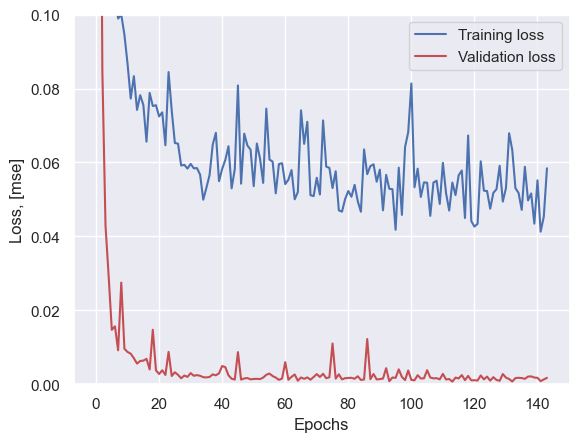

In [57]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.1])
plt.show()

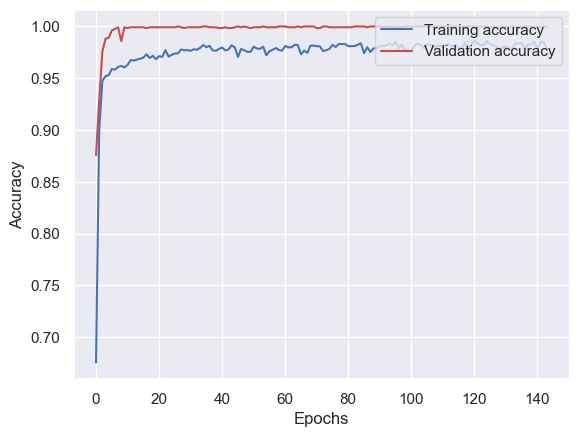

In [64]:
plt.plot(history.history['accuracy'],
         'b',
         label='Training accuracy')
plt.plot(history.history['val_accuracy'],
         'r',
         label='Validation accuracy')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim([0,.1])
plt.show()

In [63]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [84]:
y_pred = model.predict(X_test).reshape(-1)

40/40 [==============================] - 0s 3ms/step


In [85]:
y_pred

array([0.00121519, 0.00121519, 0.00121519, ..., 1.        , 1.        ,
       0.9124426 ], dtype=float32)

In [86]:
np.unique(y_pred)

array([0.00121519, 0.04479153, 0.06436075, 0.38688597, 0.9124426 ,
       0.95105916, 0.96208215, 0.9817353 , 0.98269385, 0.98672664,
       0.9901038 , 0.9921336 , 0.9933583 , 0.99661463, 0.99879754,
       0.99917465, 0.9993807 , 0.999532  , 0.9997235 , 0.9997347 ,
       0.99984026, 0.9999467 , 0.9999566 , 0.9999579 , 0.99998033,
       0.9999889 , 0.99999   , 0.99999034, 0.9999907 , 0.9999939 ,
       0.9999944 , 0.99999654, 0.9999994 , 0.9999995 , 1.        ],
      dtype=float32)

In [87]:
def prediction_(num):
    if num < 0.5:
        return 0
    else:
        1

In [80]:
y_test

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [95]:
y_pred = np.array([0 if x <= 0.5 else 1 for x in y_pred ])

In [96]:
np.unique(y_pred)

array([0, 1])

In [98]:
from sklearn.metrics import confusion_matrix,classification_report 

In [99]:
confusion_matrix(y_test,y_pred)

array([[1109,    0],
       [   0,  162]], dtype=int64)

In [101]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1109
           1       1.00      1.00      1.00       162

    accuracy                           1.00      1271
   macro avg       1.00      1.00      1.00      1271
weighted avg       1.00      1.00      1.00      1271

